In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score,roc_curve,precision_recall_curve
import pandas as pd
PATH_TO_RESULTS='results/'
PATH_TO_CSV='data/'
sns.set_theme()
sns.set_style("whitegrid")

In [7]:
def MCC(predictions,Yt,thres=.5):
    tp=np.sum((predictions>=thres)*Yt)
    fp=np.sum((predictions>=thres)*(1-Yt))
    tn=np.sum((predictions<thres)*(1-Yt))
    fn=np.sum((predictions<thres)*Yt)
    mcc=(tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return mcc

In [4]:
def ACC_MCC_AUC_AP(predictions,Yt,thres=.5):
    mask= np.logical_not(np.isnan(predictions))
    predictions=predictions[mask]
    Yt=Yt[mask]
    
    mcc=round(MCC(predictions,Yt,thres),3)
    acc=round(np.sum((predictions>=thres)==Yt)/len(Yt),3)
    try:
        roc_auc=round(roc_auc_score(Yt,predictions),3)
    except:
        roc_auc=0
    try:
        aver_precision_score=round(average_precision_score(Yt,predictions),3)
    except:
        aver_precision_score=0
    return acc,mcc,roc_auc,aver_precision_score

In [5]:
def best_cross_val(model='lstm',name='random',suffix='50_1000'):

    if model=='bilstm':
        num=3
    else:
        num=5

    scores=np.zeros(num)
    for n_i in range(num):
        predictions=np.load(f'{PATH_TO_RESULTS}results_valid_{model}_orig_{name}_{suffix}_{n_i}.npy')
        Yv=np.load(f'{PATH_TO_RESULTS}true_valid_{model}_orig_{name}_{suffix}_{n_i}.npy')
        scores[n_i]=ACC_MCC_AUC_AP(predictions,Yv)[1]
    return np.argmax(scores)

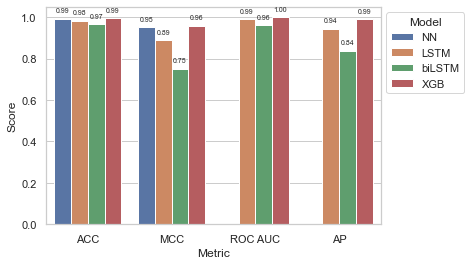

In [11]:
models=['nn','lstm','bilstm','xgb']
results=[]
name="random"
suffix="full_1000" # Figure 1: a) 'full_1000' b) '50' c) '50_1000'
model_names={'nn':'NN','xgb':'XGB','lstm':'LSTM','bilstm':'biLSTM'}
test_set=pd.read_csv(f"{PATH_TO_CSV}{name}_test_{suffix}.csv")
Yt=test_set['dna_binding'].values
for i, model in enumerate(models):
    if model in ["lstm","bilstm"]:
        n_i=best_cross_val(model,name,suffix)
        pred=np.load(f'{PATH_TO_RESULTS}results_{model}_orig_{name}_{suffix}_{n_i}.npy')
    else:
        pred=np.load(f'{PATH_TO_RESULTS}results_{model}_{name}_{suffix}.npy')
    
    
    if model=="nn":
        acc,mcc,auc,aver_precision_score=ACC_MCC_AUC_AP(pred,Yt)
        results.append(('ACC',acc,f'{model_names[model]}'))
        results.append(('MCC',mcc,f'{model_names[model]}'))
    else:
        for label,score in zip(['ACC','MCC','ROC AUC','AP'],ACC_MCC_AUC_AP(pred,Yt)):
            results.append((label,score,f'{model_names[model]}'))
df_results=pd.DataFrame(data=results,columns=['Metric','Score','Model'])
plots = sns.barplot(data=df_results,x='Metric',y='Score',hue='Model')
for bar in plots.patches: 
    plots.annotate(format(bar.get_height(), '.2f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=7, xytext=(0, 8), 
                   textcoords='offset points')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left',title='Model')
plt.ylim([0,1.05])

(0.0, 1.05)

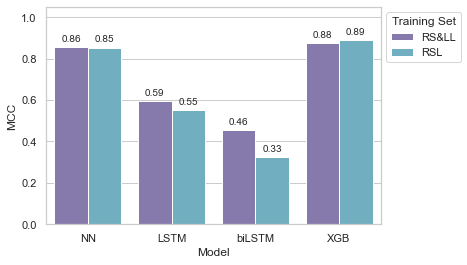

In [12]:
#figure 1d)
models=['nn','lstm','bilstm','xgb']
results=[]
name="random"
suffix="50_1000"
model_names={'nn':'NN','xgb':'XGB','lstm':'LSTM','bilstm':'biLSTM'}
test_set=pd.read_csv(f"{PATH_TO_CSV}{name}_test_{suffix}.csv")
Yt=test_set['dna_binding'].values
for i, model in enumerate(models):
    if model in ["lstm","bilstm"]:
        n_i=best_cross_val(model,name,suffix)
        pred=np.load(f'{PATH_TO_RESULTS}results_{model}_orig_{name}_{suffix}_{n_i}.npy')
    else:
        pred=np.load(f'{PATH_TO_RESULTS}results_{model}_{name}_{suffix}.npy')
    
    
    if model=="nn":
        acc,mcc,auc,aver_precision_score=ACC_MCC_AUC_AP(pred,Yt)
        results.append(('ACC',acc,f'{model_names[model]}','RS&LL'))
        results.append(('MCC',mcc,f'{model_names[model]}','RS&LL'))
    else:
        for label,score in zip(['ACC','MCC','AUC','AP'],ACC_MCC_AUC_AP(pred,Yt)):
            results.append((label,score,f'{model_names[model]}','RS&LL'))

models=['nn','lstm','bilstm','xgb']
name="random"
suffix="50"
model_names={'nn':'NN','xgb':'XGB','lstm':'LSTM','bilstm':'biLSTM'}
test_set=pd.read_csv(f"{PATH_TO_CSV}{name}_test_{suffix}.csv")
Yt=test_set['dna_binding'].values
Yt_len=test_set['Length'].values
mask=Yt_len<=1000
for i, model in enumerate(models):
    if model in ["lstm","bilstm"]:
        n_i=best_cross_val(model,name,suffix)
        pred=np.load(f'{PATH_TO_RESULTS}results_{model}_orig_{name}_{suffix}_{n_i}.npy')
    else:
        pred=np.load(f'{PATH_TO_RESULTS}results_{model}_{name}_{suffix}.npy')
    
    if model=="nn":
        acc,mcc,auc,aver_precision_score=ACC_MCC_AUC_AP(pred[mask],Yt[mask])
        results.append(('ACC',acc,f'{model_names[model]}','RSL'))
        results.append(('MCC',mcc,f'{model_names[model]}','RSL'))
    else:
        for label,score in zip(['ACC','MCC','AUC','AP'],ACC_MCC_AUC_AP(pred[mask],Yt[mask])):
            results.append((label,score,f'{model_names[model]}','RSL'))
df_results=pd.DataFrame(data=results,columns=['Metric','Score','Model','Training Set'])
plots = sns.barplot(data=df_results[df_results['Metric']=='MCC'],x='Model',y='Score',hue='Training Set',
                    palette=[(0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
                             (0.39215686274509803, 0.7098039215686275, 0.803921568627451)])
for bar in plots.patches:  
    plots.annotate(format(bar.get_height(), '.2f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=10, xytext=(0, 8), 
                   textcoords='offset points')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left',title='Training Set')
plt.ylabel('MCC')
plt.ylim([0,1.05])

In [ ]:
#Used in figure 2
test_set=pd.read_csv(f'{PATH_TO_CSV}random_test_50_1000.csv')
pred1=np.load(f'{PATH_TO_RESULTS}results_xgb_random_50_1000.npy')
pred2=np.load(f'{PATH_TO_RESULTS}results_nn_random_50_1000.npy')
pred3=np.load(f'{PATH_TO_RESULTS}results_lstm_orig_random_50_1000_3.npy')
pred4=np.load(f'{PATH_TO_RESULTS}results_bilstm_orig_random_50_1000_2.npy')
test_set['xgb_pred']=pred1
test_set['nn_pred']=pred2
test_set['lstm_pred']=pred3
test_set['bilstm_pred']=pred4
test_set_dbd_flip=pd.read_csv(f'{PATH_TO_CSV}random_test_50_1000_dbd_flip.csv')
pred1=np.load(f'{PATH_TO_RESULTS}results_xgb_random_dbd_flip.npy')
pred2=np.load(f'{PATH_TO_RESULTS}results_nn_random_50_1000_dbd_flip.npy')
pred3=np.load(f'{PATH_TO_RESULTS}results_lstm_orig_random_50_1000_dbd_flip_3.npy')
pred4=np.load(f'{PATH_TO_RESULTS}results_bilstm_orig_random_50_1000_dbd_flip_2.npy')
test_set_dbd_flip['xgb_pred_flip']=pred1
test_set_dbd_flip['nn_pred_flip']=pred2
test_set_dbd_flip['lstm_pred_flip']=pred3
test_set_dbd_flip['bilstm_pred_flip']=pred4
test_set_random_flip=pd.read_csv(f'{PATH_TO_CSV}random_test_50_1000_random_flip.csv')
pred1=np.load(f'{PATH_TO_RESULTS}results_xgb_random_random_flip.npy')
pred2=np.load(f'{PATH_TO_RESULTS}results_nn_random_random_flip.npy')
pred3=np.load(f'{PATH_TO_RESULTS}results_lstm_orig_random_50_1000_random_flip_3.npy')
pred4=np.load(f'{PATH_TO_RESULTS}results_bilstm_orig_random_50_1000_random_flip_2.npy')
test_set_random_flip['xgb_pred_rand']=pred1
test_set_random_flip['nn_pred_rand']=pred2
test_set_random_flip['lstm_pred_rand']=pred3
test_set_random_flip['bilstm_pred_rand']=pred4
test_set_not_dbd_flip=pd.read_csv(f'{PATH_TO_CSV}random_test_50_1000_not_dbd_flip.csv')
pred1=np.load(f'{PATH_TO_RESULTS}results_xgb_random_not_dbd_flip.npy')
pred2=np.load(f'{PATH_TO_RESULTS}results_nn_random_not_dbd_flip.npy')
pred3=np.load(f'{PATH_TO_RESULTS}results_lstm_orig_random_50_1000_not_dbd_flip_3.npy')
pred4=np.load(f'{PATH_TO_RESULTS}results_bilstm_orig_random_50_1000_not_dbd_flip_2.npy')
test_set_not_dbd_flip['xgb_pred_not_dbd']=pred1
test_set_not_dbd_flip['nn_pred_not_dbd']=pred2
test_set_not_dbd_flip['lstm_pred_not_dbd']=pred3
test_set_not_dbd_flip['bilstm_pred_not_dbd']=pred4
test_set_dbd_flip['original_entry']=[i.split('_')[0] for i in test_set_dbd_flip['Entry'].values]
test_set_random_flip['original_entry']=[i.split('_')[0] for i in test_set_random_flip['Entry'].values]
test_set_not_dbd_flip['original_entry']=[i.split('_')[0] for i in test_set_not_dbd_flip['Entry'].values]
df=pd.merge(test_set_dbd_flip,test_set,left_on='original_entry',right_on='Entry')
df=pd.merge(df,test_set_random_flip,on='original_entry')
df=pd.merge(df,test_set_not_dbd_flip,on='original_entry')

In [ ]:
model='lstm' #Figure 2 a) 'nn' b) 'lstm' c) 'bilstm' d) 'xgb'
T=np.linspace(0,1,1001)
original=np.zeros(1001)
dbd=np.zeros(1001)
not_dbd=np.zeros(1001)
random=np.zeros(1001)
N=df.shape[0]
for i,t in enumerate(T):
    original[i]=np.sum(df[f'{model}_pred'].values>=t)/N
    dbd[i]=np.sum(df[f'{model}_pred_flip'].values>=t)/N
    random[i]=np.sum(df[f'{model}_pred_rand'].values>=t)/N
    not_dbd[i]=np.sum(df[f'{model}_pred_not_dbd'].values>=t)/N
plt.plot(T,original,linewidth=2,linestyle='-')
plt.plot(T,dbd,linewidth=2,linestyle='--')
plt.plot(T,random,linewidth=2,linestyle='-.')
plt.plot(T,not_dbd,linewidth=2,linestyle='dotted')
plt.ylabel("Recall*")
plt.ylim([-.05,1.05])
plt.xlabel("Threshold")
plt.legend(["Original","DBR flipped","Random region flipped","Everything but DBR flipped"])

In [ ]:
# Used in figure 3
# Need to run 'make_data_for_species_test.py' before this code
models=['nn','xgb']
model_names={'nn':'NN','xgb':'XGB'}
names=['ecoli','sal','staph','tb','bacs','strepy',"bacc","strepn"]
results=[]
train_label={'euk':'Eukaryotes','bac':'Bacteria','all':'Eukaryotes/Bacteria'}
for model in models:
    for suffix in ['bac','euk','all']:
        for name in names:
            if suffix=='all':
                test_set=pd.read_csv(f"{PATH_TO_CSV}{name}_test_bac.csv")
            else:
                test_set=pd.read_csv(f"{PATH_TO_CSV}{name}_test_{suffix}.csv")
            Yt=test_set['dna_binding'].values
            pred=np.load(f'{PATH_TO_RESULTS}results_{model}_{name}_{suffix}.npy')
            if model=='xgb':
                thres=.5
                for label,score in zip(['ACC','MCC','AUC','AP'],ACC_MCC_AUC_AP(pred,Yt,thres)):
                    results.append((name,train_label[suffix],label,score,f'{model_names[model]}'))
                for label,score in zip(['Precision','Recall'],percision_recall(pred,Yt,thres)):
                    results.append((name,train_label[suffix],label,score,f'{model_names[model]}'))
            else:
                for label,score in zip(['ACC','MCC','AUC','AP'],ACC_MCC_AUC_AP(pred,Yt,.5)):
                    results.append((name,train_label[suffix],label,score,model_names[model]))
                for label,score in zip(['Precision','Recall'],percision_recall(pred,Yt,.5)):
                    results.append((name,train_label[suffix],label,score,model_names[model]))
df_results=pd.DataFrame(data=results,columns=['Species' ,'Training Set','Metric','Score','Model'])

In [ ]:
#Figure 3a)
sns.boxplot(data=df_results[df_results['Metric']=='MCC'],hue='Model',
            y='Score',x='Training Set',palette=[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
                                               (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)])
plt.ylim([0,1.05])
plt.ylabel("MCC")

In [ ]:
#Figure 3b)
sns.boxplot(data=df_results[df_results['Metric']=='Precision'],hue='Model',
            y='Score',x='Training Set',palette=[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
                                               (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)])
plt.ylim([0,1.05])
plt.ylabel("Precision")

In [ ]:
#Figure 3c)
sns.boxplot(data=df_results[df_results['Metric']=='Recall'],hue='Model',
            y='Score',x='Training Set',palette=[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
                                               (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)])
plt.ylim([0,1.05])
plt.ylabel("Recall")

In [ ]:
#Figure 3d)
sns.boxplot(data=df_results[np.logical_and(df_results['Model']=='XGB',df_results['Metric'].isin(['AP']))],hue='Model',
            y='Score',x='Training Set',palette=[(0.7686274509803922, 0.3058823529411765, 0.3215686274509804)])
plt.ylim([0,1.05])
plt.ylabel("AP")

In [ ]:
# Used in figure 4
# Need to run 'make_data_for_species_test.py' before this code
models=['nn','xgb']
names=['human','mouse_ear','mouse','rice','rat','yeast',"frog","fly"]
model_names={'nn':'NN','xgb':'XGB'}
results=[]
train_label={'euk':'Eukaryotes','bac':'Bacteria','all':'Eukaryotes/Bacteria'}
for model in models:
    for suffix in ['euk','bac','all']:
        for name in names:
            if suffix=='all':
                test_set=pd.read_csv(f"{PATH_TO_CSV}{name}_test_euk.csv")
            else:
                test_set=pd.read_csv(f"{PATH_TO_CSV}{name}_test_{suffix}.csv")
            Yt=test_set['dna_binding'].values
            pred=np.load(f'{PATH_TO_RESULTS}results_{model}_{name}_{suffix}.npy')
            if model=='xgb':
                thres=.5
                for label,score in zip(['ACC','MCC','AUC','AP'],ACC_MCC_AUC_AP(pred,Yt,thres)):
                    results.append((name,train_label[suffix],label,score,f'{model_names[model]}'))
                for label,score in zip(['Precision','Recall'],percision_recall(pred,Yt,thres)):
                    results.append((name,train_label[suffix],label,score,f'{model_names[model]}'))
            else:
                for label,score in zip(['ACC','MCC','AUC','AP'],ACC_MCC_AUC_AP(pred,Yt,.5)):
                    results.append((name,train_label[suffix],label,score,model_names[model]))
                for label,score in zip(['Precision','Recall'],percision_recall(pred,Yt,.5)):
                    results.append((name,train_label[suffix],label,score,model_names[model]))
df_results=pd.DataFrame(data=results,columns=['Species' ,'Training Set','Metric','Score','Model'])

In [ ]:
# Figure 4a)
sns.boxplot(data=df_results[df_results['Metric']=='MCC'],hue='Model',
            y='Score',x='Training Set',palette=[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
                                               (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)])
plt.ylim([0,1.05])
plt.ylabel("MCC")

In [ ]:
# Figure 4b)
sns.boxplot(data=df_results[df_results['Metric']=='Precision'],hue='Model',
            y='Score',x='Training Set',palette=[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
                                               (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)])
plt.ylim([0,1.05])
plt.ylabel("Precision")

In [ ]:
#Figure 4c)
sns.boxplot(data=df_results[df_results['Metric']=='Recall'],hue='Model',
            y='Score',x='Training Set',palette=[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
                                               (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)])
plt.ylim([0,1.05])
plt.ylabel("Recall")

In [ ]:
#Figure 4d)
sns.boxplot(data=df_results[np.logical_and(df_results['Model']=='XGB',df_results['Metric'].isin(['AP']))],hue='Model',
            y='Score',x='Training Set',palette=[(0.7686274509803922, 0.3058823529411765, 0.3215686274509804)])
plt.ylim([0,1.05])
plt.ylabel("AP")